# Datasets

The time-series analysis will focus on two primary datasets:

 1. An experimental building dataset from Los Alamos National Laboratories. [1]
 2. An aerospace simulation dataset, which has a recording at two flight phases, in which damage is introduced. [2]
 
## Building Dataset
 
Briefly, the building dataset is physically set-up as follows:

<img src="Images/building_sensors.PNG">


The building dataset was an extensive investigation in applying:

 1. Different levels of damage, at
 2. Different locations on the structure, with
 3. Different voltage levels.
 
In order to model the steady progression of damage on our structure we considered the following transition: 

**Healthy -> Mild damage at location 1C -> Large damage at location 1C -> Large damage at locations 1C and 3A**

where mild damage is taken to mean loosening of a bolt, and large damage is taken to mean complete removal of a bracket which holds the strut at that location.


## Aerospace Dataset

The aerospace dataset is based on an in-house 2D wing simulation based on  flat-plate pitch-plunge model, with the two control surfaces modeled. Attached to the 2D wing are two control surfaces, and five sensors: 
 
 - Two sensors are on the wing tip
 - Two sensors are at wing mid-span
 - One sensor is on the first control surface, where damage will be introduced
 
The physical characteristsics of the 2D wing (including a brief over-view of the 2D strip modeling) is as follows:

<img src="Images/wing_top.PNG" width="700">

<img src="Images/wing_iso.PNG" width="700">
 
The purpose of aerospace dataset is to represent a situation that has:

 1. **Low data cardinality:** In expensive, dynamical systems one does not have the luxury to take measurements at will
 2. **Multiple transitionary phases:** Note that an aircraft will experience various flight phases during operation. In an naive anomaly detection algorithm, each flight phase transition *will* be classed as an anomaly to one another. Therefore there is a need to pin-point the difference(s) between normal flight transitions **and** when damage has occured, which requires a sophisticated look at anomaly detection. 
 
In order to achieve point 2 for the aerospace dataset, the following transitions are modeled:

 1. Take-off phase
 2. Climb phase
 3. Climb phase with damage
 
based on an assumed **single** flight regime (recall that test flights are expensive to organize, therefore we challenege the analysis for low data cardinality analysis). Note that technically this represents **three** data-points meaning that whilst a Tensor Decomposition may be OK for the static *building dataset*, it may not (as will be shown) suffice for the aerospace setting. 

Note that reference [2] has successfully applied Tensor Decomposition for the same wing model. However, it must be noted that *a lot* of artificial data was generated, and different flight regimes were not considered, which makes the analysis [2] slightly easier (and slightly more removed from reality). 

In principle, since this is a simulation proof-of-concept the prescribed deflections over the controls surfaces *are not* representative of a real aircraft's flight maneavure during these flight phases. However, control surface deflections were chosen loosely based on an understanding on what the desired physics should he in those flight phases. For example: 

 1. Take-off usually aims for high lift coefficient corresponding to larger control surface deflections
 2. During climb phase one still deflects the controls surfaces but usually at lower angles of attack
 3. The in-board contorl surface usually deflects less than the out-board control surface (due to moment rotations)
 4. Velocity and ambient air density (i.e. dynamic pressure) differ between take-off and climb (naturally because of the change in altitude). 

 [1] https://www.lanl.gov/projects/national-security-education-center/engineering/software/shm-data-sets-and-software.php
 
 [2] Cheema, P., Nguyen, K., Kidd, M., & Vio, G. A. (2019). A Tensor-based Structural Health Monitoring Approach for Aeroservoelastic Systems. In AIAA Scitech 2019 Forum (p. 1964).

# Code

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
data_path = os.path.abspath(os.path.join('..\\data\\sensor_data')) + '\\'
    
import numpy as np 

from modules.timeSeriesModels.TimeSeriesAnalysis import TensorDecomp, MatrixProfile, ChangePoint 

# Tensor Decomposition


When working with the tensor decomposition, note that the user has the ability to specify two hyper-parameters:
 
 1. ``num_dims=2``
 2. ``num_dims=3``
 
This is because the following data arangements are possible:

## ``num_dims=2``

This results in the following 2D stacking of various sensors

<img src="Images/sensors_2D_stack.PNG" width="220">



## ``num_dims=3``

This results in the following 3D stacking of various sensors

<img src="Images/sensors_3D_stack.PNG"  width="220">


The reasons for such stackings is to try and enforce a type of **ensembling** amongst the sensor array data. Notice that for a 2D type arrangment, there is *much more* data theoretically available (because there are many more *rows*). 

For a 3D data arrangment, we gain an extra dimension of analysis (i.e. one can monitor the sensor space and event spaces separately - where event space could mean healthy data, or damage data events). However, we lose some amount of data. 

In situations where data monitoring is difficult, or sparse (practically due to physical, time or monetary constraints), a lot of information could be lost in the ``num_dims=3`` setting. This will be made clear when considering the *aerospace* dataset. 


**Note:**

 - In general the time / frequency axis decomposition does not give very useful information, so it is left-out in analysis. The most useful axes for consideration are *Event Space*

4489.578131572949


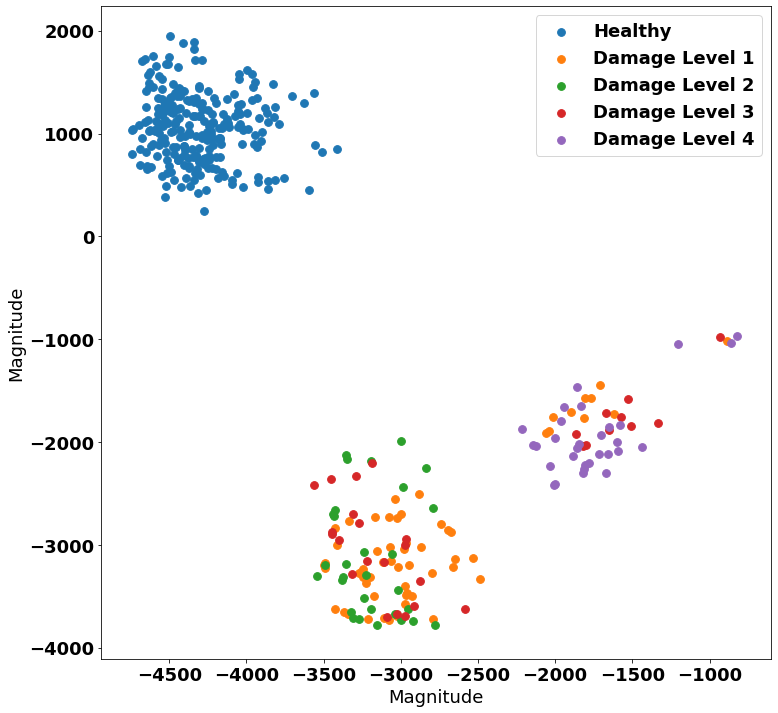

In [6]:
TD = TensorDecomp(num_dims=2, data_path=data_path)

TD.fit(data_type='Building', sensor_nums=[1,2,3,4,5,6,7,8,9,10])

print(TD.error())

TD.plot()

Notice that when performing the 2D decomposition on 3D stacked data we extract information about the sensor space also: i.e. sensors that are mapped closer to one another most likely behave with similar characteristics with respect to one another. 

Therefore a tensor-based approach has some advantages when trying to pool together information from multiple sources.

**However:** Relalize that even though the separation between healthy and damage appears good, tensor decompositino is unable to characterize the different damage states (all unhealthy data gets mapped on top of one another).

9621.36766629084


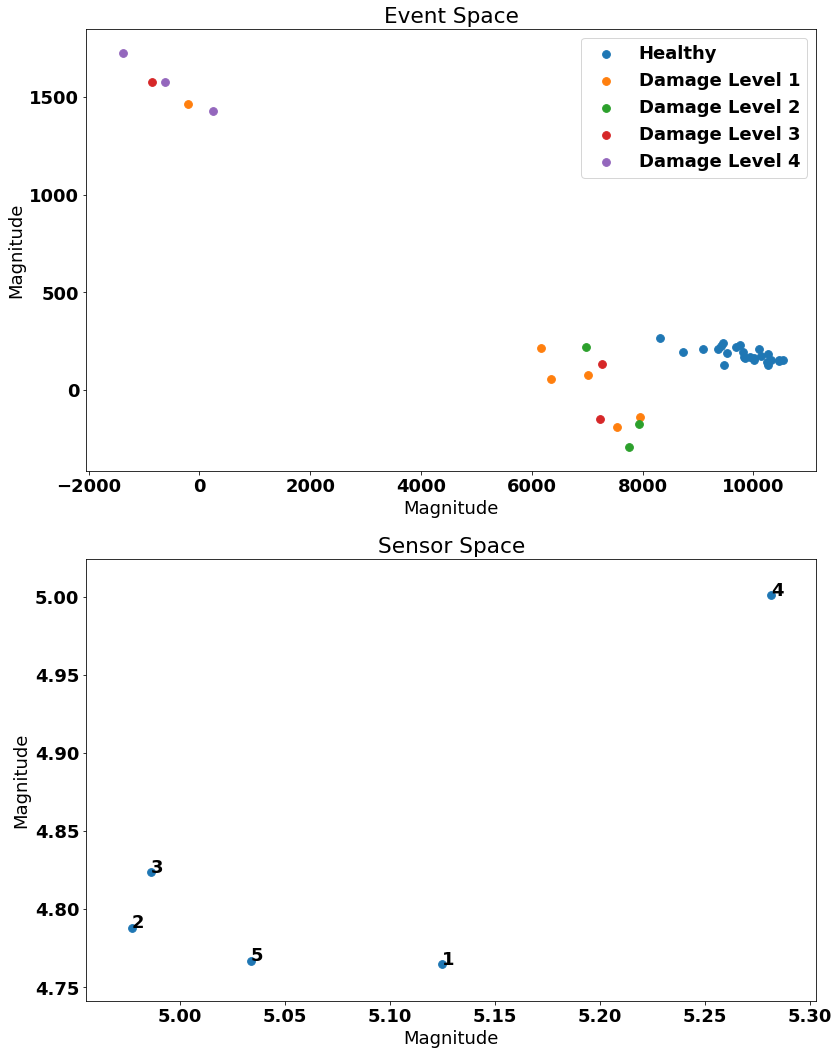

In [7]:
TD = TensorDecomp(num_dims=3, data_path=data_path)

TD.fit(data_type='Building', sensor_nums=[1,2,3,4,5])

print(TD.error())

TD.plot()

As can be seen below, the propposed aircraft data is low cardinality. Thus, whilst tensor decomposition is great for the building dataset, it will suffer (and could give silly results) in such situations where data cardinality is unforunately low (either due to time, monetary, or other physical constraints). 

There is still useful information (e.g. observe sensor groupings in 3D decomp.), but we loose a lot of the useful shape information of the time series which is critical when there is a lack of "events"

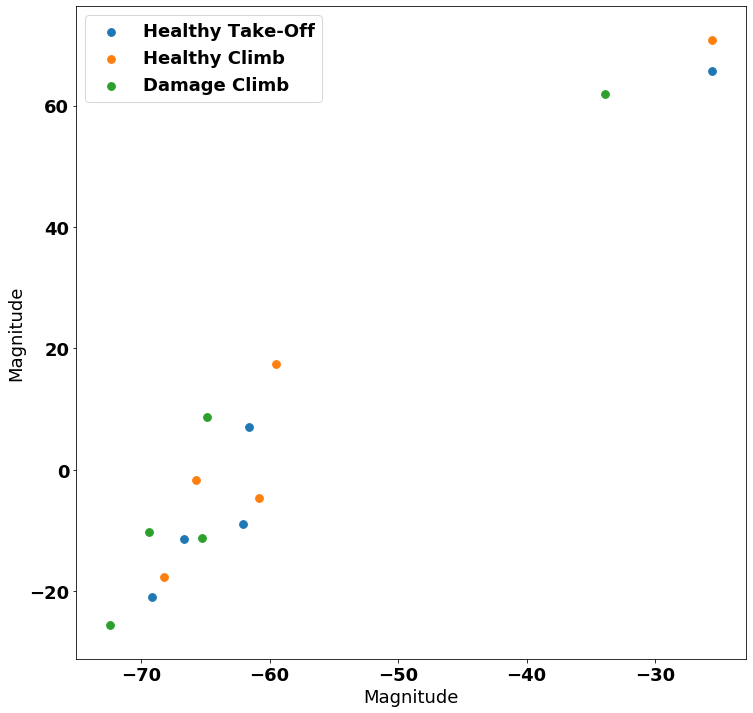

In [8]:
TD = TensorDecomp(num_dims=2, data_path=data_path)

TD.fit(data_type='Aircraft', sensor_nums=[1,2,3,4,5])

TD.plot()

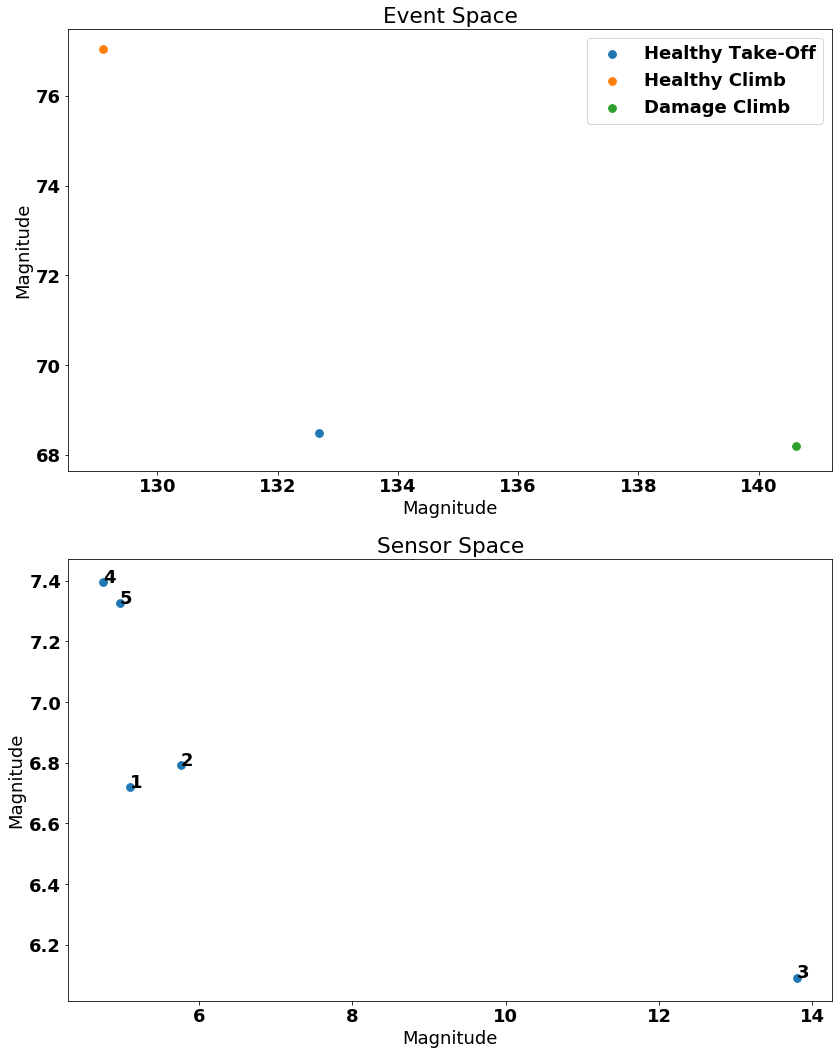

In [10]:
# Notice that sensors 4-5, 1-2, and 3 tend to group separately. 
# This makes sense based on the sensor arrangement over the 2D wing.
TD = TensorDecomp(num_dims=3, data_path=data_path)

TD.fit(data_type='Aircraft', sensor_nums=[1,2,3,4,5])

TD.plot()

# Matrix Profiling

Matrix profiling refers to an efficient implementation of the *all-paris-similarity-search* over times series, and general signal sequences. The all-pairs-similarity-search is a difficult problem which attempts to compare every subsequence of signal possible across itself. Evidently this algorithm scales on the scale of $O(n^2m)$, where $n$ is the length of time series, and $m$ the length of the nominated subsequence, and would require $O(n^2)$ storage space. 

For example, for a time series of length 525,600, a self-similarity comparison of length 10,080 over this signal will require a nested loop with 132,880,692,960 total computations. If each computation requires 0.0001 seconds to run then the total algorithm will run for 153.8 days, which therefore renders the problem traditionally unfeasible. However, the recent innovations in the form of calculating a matrix profile would reduce the 153.8 days run time down to 6.3 hours in total, representing a 99.8% increase in efficiency!

In particular, the STAMP algorithm (Scalable Time series Anytime Matrix Profile), and later the STOMP, and SCRIMP algorithms which have been developed, and refined since 2016 aim to represent an efficient way to calcualte this matrix profile. In particular, they reduce the computational complexity to $O(n^2\log(n))$ (with empirical observations being approximately $O(n^2)$), and the space compexity to $O(n)$. 

The space complexity is reduced as such by noticing that the matrix profile only stored the 1-NN of the Euclidean disitance to a subsequence and a matching subsequence in the neighbouring signal. The following gif clarifies this.


<img src="Images/matrix_profile.gif">


Since one is only storing the 1-NN subsequence distance, the matrix profile acts as a lower-bound estimator on the meta-characteristics of the time signal.

Moreover the $O(n^2\log(n))$ spatial complexity arises by noticing that the subsequence distance calculations are essentially a *discrete convolution*. Therefore by invoking the **Convolution Theorem**, one can perform a fast Fourier transform (FFT) and take the dot-product between in the frequence space, so that the convolution in the time space is realized. 

Because the FFT is one of the most popular tools in computational science, modern algorithms have compressed the FFT calculation to approximately $O(nlog(n))$, with it behaving as approximatley $O(n)$ in many settings. Finally, by employing some clever usage of dynamic programming techniques (in particular, storing and updating minimum values across overlapping sub-problems), one can now push the matrix profile calculation to approximatly $O(n^2)$. 


The matrix profile of a time series conveys a lot of useful information. For example:

 1. Points of maximum suggest anomalous behaviors
 2. Repeated points of minimum suggest the existance of motifs across the time series
 3. Tracking the *matrix profile index* allows one to segment the time series into its semantic behaviors
 
Ultimately the matrix profile is calculated across each sensor setting, and the information is pooled together in these dataset by calculating the *Barycentre*. This is because barycentre calcualtions are good at:

 1. Preserving *shape* information
 2. Weighting particular signal components over the other
 
Point 1. is needed because sensor informatino is often *lagged* meaning that a naive mean calcualtion can often eliminate important signal characteristics. Moreover Point 2. is important because certain sensors convey damage (and vibrational) characteristics better than others (for example, the end  of a cantilever beam will vibrate with greater magnitude than a mid-span point. Therefore a sensor on the end of a cantilever beam will provide more useful information than that of the mid-span configurations).

C:\ProgramData\Anaconda3\lib\site-packages\stumpy\aamp.py:193: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  ndist_counts = core._count_diagonal_ndist(diags, m, n_A, n_B)


Proposed change point locations: [array([ 5102,  7102,  9102, 11102]), array([ 2789,  4789,  7003,  9003, 11003])]
log-L2 Norm away from ground truth locations: 14.900105899960908


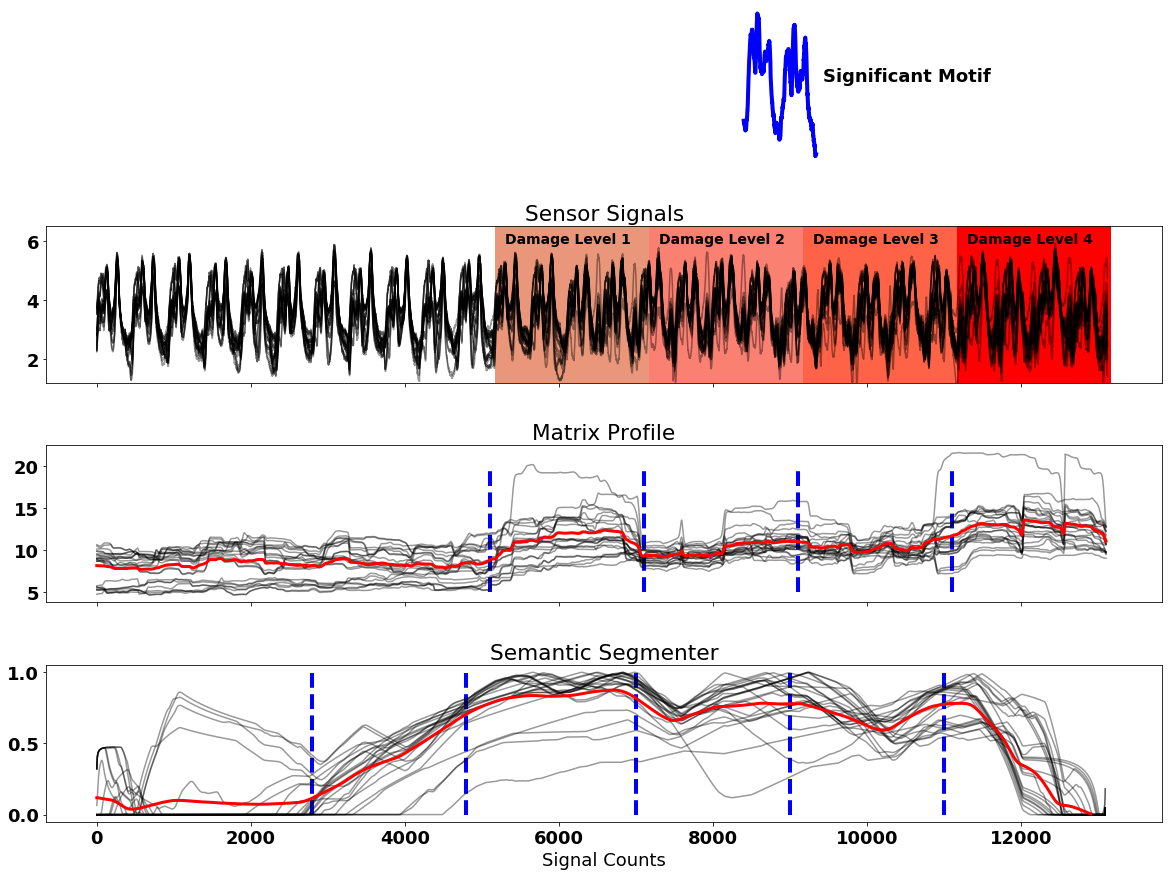

In [2]:
MP = MatrixProfile(data_path=data_path)

# Use all sensors
MP.fit(data_type = 'Building', sensor_nums = np.arange(1,25))

# Predict where the change points may occur
# i.e. run a change point analysis on top of the matrix profiler
chg_pts = MP.predict()

# Error with respect ground truth damage times
# L2 norm between change point locations and ground truth
error = MP.error()

print(f'Proposed change point locations: {chg_pts}')
print(f'log-L2 Norm away from ground truth locations: {np.log(error)}')

MP.plot()

Observe the difference in matrix profiling with and without sensor 3 (criticial sensor for this context). Semantic segmentor picks up change in flight phase as something anamolous ... false alarm!

Proposed change point locations: [array([1056, 4553]), array([4060, 4922])]
log-L2 Norm away from ground truth locations: 13.840509952760465


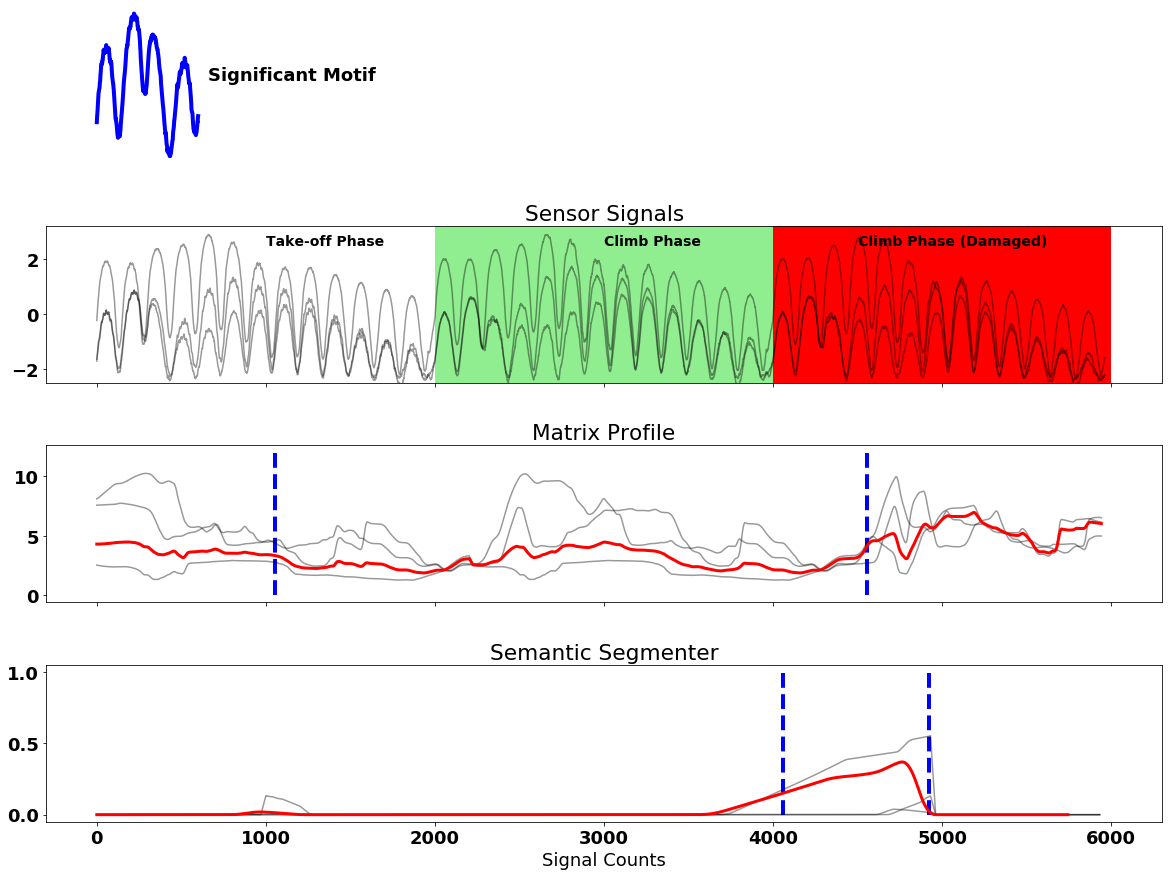

In [6]:
# Aircraft with most important sensors for (i) Flight change patterns, (ii) Damage detection
MP = MatrixProfile(data_path=data_path)

MP.fit(data_type = 'Aircraft', sensor_nums = [1,2,3])

chg_pts = MP.predict()

error = MP.error()

print(f'Proposed change point locations: {chg_pts}')
print(f'log-L2 Norm away from ground truth locations: {np.log(error)}')

MP.plot()

Proposed change point locations: [array([ 502, 2396]), array([4467, 4967])]
log-L2 Norm away from ground truth locations: 14.390436544390429


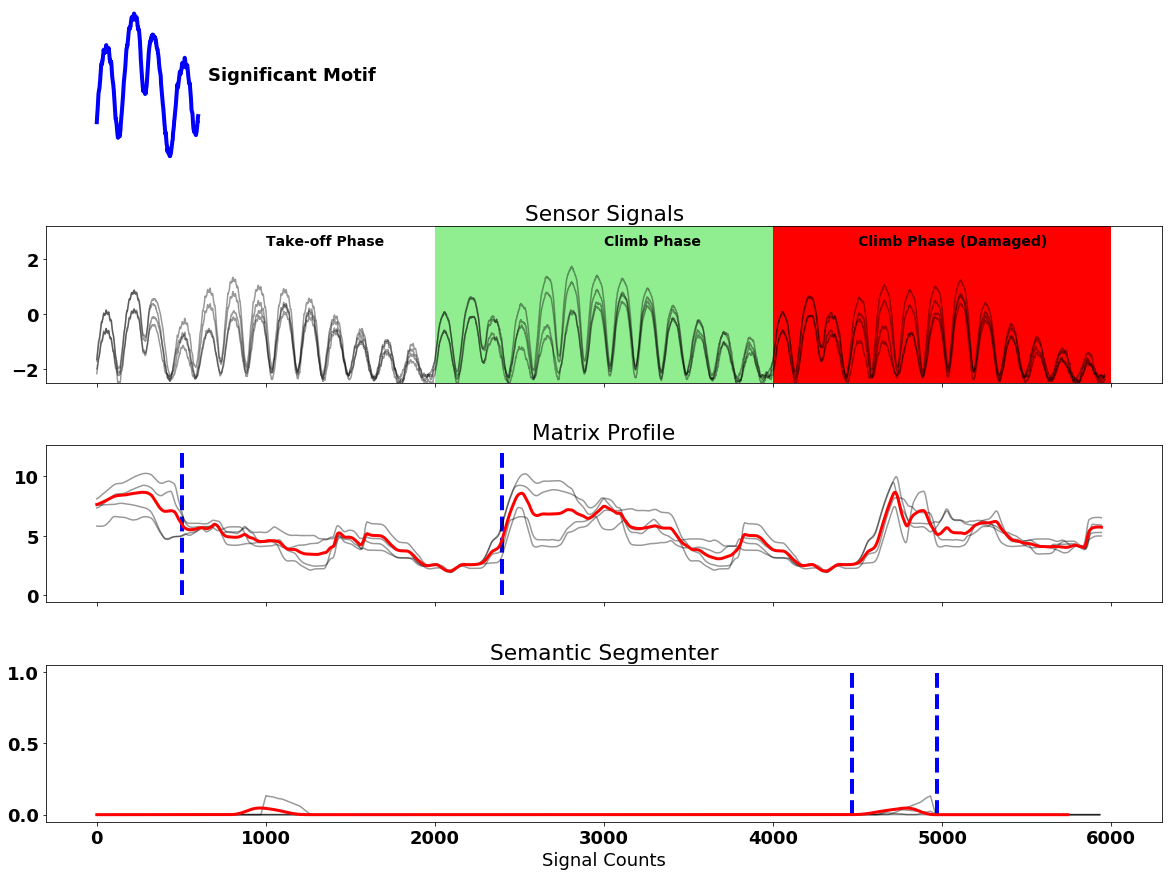

In [5]:
# Aircraft -- no sensor 3 (critical damage sensor)
MP = MatrixProfile(data_path=data_path)

MP.fit(data_type = 'Aircraft', sensor_nums = [1,2,4,5])

chg_pts = MP.predict()

error = MP.error()

print(f'Proposed change point locations: {chg_pts}')
print(f'log-L2 Norm away from ground truth locations: {np.log(error)}')

MP.plot()

# Change Point Analysis


16.815663545746403


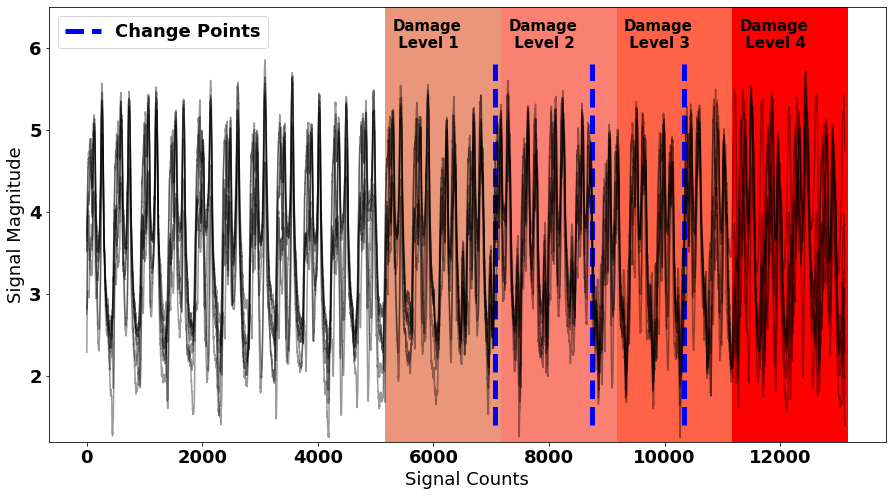

In [9]:
CP = ChangePoint(data_path=data_path)

CP.fit(data_type = 'Building', sensor_nums = [4,2,5,7,9,23,21])

CP.predict()

print(np.log(CP.error()))

CP.plot()

Notice change point analyzer tends to put too many change points (and lag them by too much), when not enough sensors are used. Therefore, more sensors ==> better analysis. Of course!  

However, it seems even if all five sensors are used, the climb phase damage is still detected too late. Perhaps either better (i) Pre-processing needed, (ii) Better ensembling, (iii) More data+sensors

[2622 3306 5310]


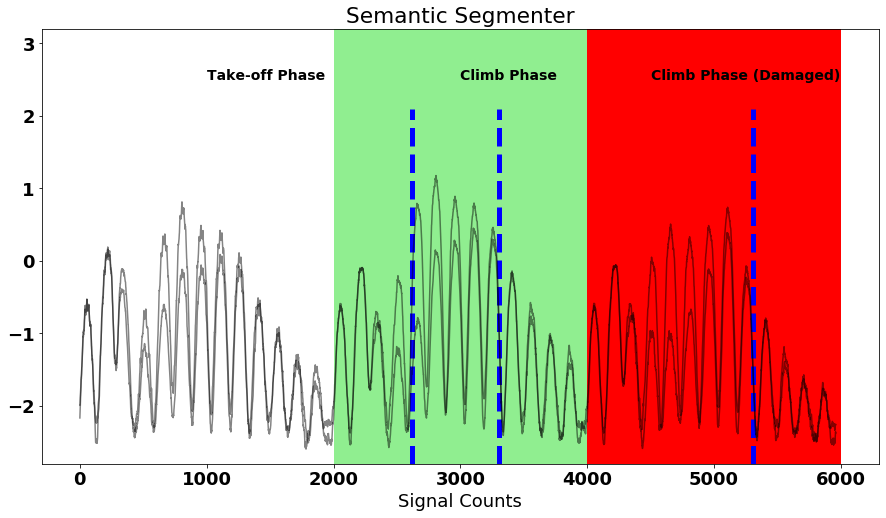

In [4]:
CP = ChangePoint(data_path=data_path)

CP.fit(data_type = 'Aircraft', sensor_nums = [4,5], min_size=200)

chg_pt_locs = CP.predict()

# Need to run .predict() before plot function (as it will plot the calculated chg pts)
CP.plot()

print(chg_pt_locs)

[2013 5310]


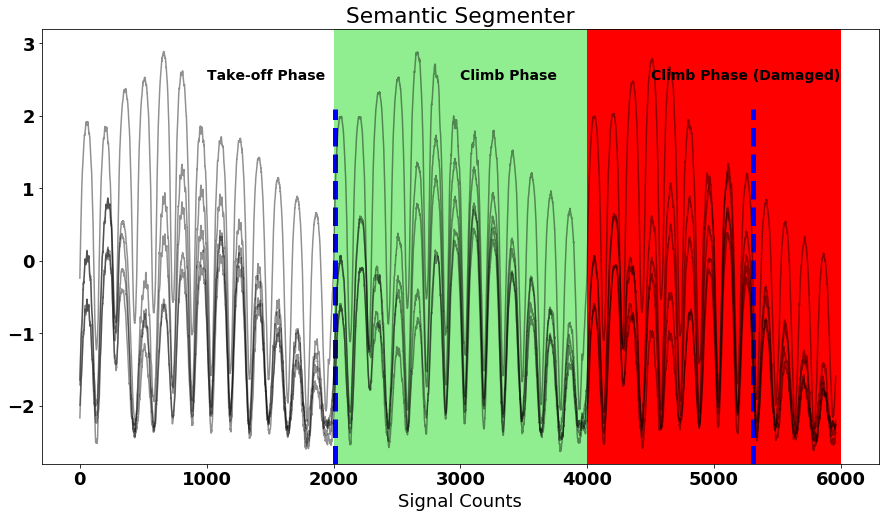

In [5]:
CP = ChangePoint(data_path=data_path)

CP.fit(data_type = 'Aircraft', sensor_nums = [1,2,3,4,5], min_size=200)

chg_pt_locs = CP.predict()

CP.plot()

print(chg_pt_locs)